In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
import cv2

from PIL import Image

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

tf.config.run_functions_eagerly(True)
tf.executing_eagerly()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

In [2]:

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')



In [17]:
tf_data=tf.data.Dataset.list_files("skycamera_images - Copie/*/*")

In [12]:
"""str_=b'DATA_copie\\2021-11-04\\08-24.jpg'
str_=str_.decode()
str_=os.path.join("labels",str_.split("\\")[1],str_.split("\\")[2].split(".")[0]+".txt")
print(str_)

def get_label_from_file(filepath):
    
    time=tf.strings.split(filepath,sep="\\")[2]
    
    label_path=tf.strings.join(["labels",tf.strings.split(filepath,sep="\\")[1],tf.strings.split(time,sep=".")[0]+tf.constant(".txt")],separator="\\")
    return label_path
"""

def get_date_time(filepath):
    tf.compat.v1.enable_eager_execution()
    
    date=tf.strings.split(filepath,sep="\\")[1]
    time=tf.strings.split(filepath,sep="\\")[2]

    hours = tf.strings.substr(time, pos=0, len=2)
    minutes = tf.strings.substr(time, pos=3, len=2)  # Corrected length
    seconds = "00"
    
    time_components = [hours, minutes, seconds]
    time_string = tf.strings.join(time_components, separator=":")
    #print("ok",time_string)
    time=time_string.numpy().decode()

    date=date.numpy().decode()
    #print("ok")

    return date,time

                           
#for element in tf_data.map(get_label_from_dataframe).take(5):
#    print(element)

In [ ]:
def get_label(filepath):
    date,time=get_date_time(filepath)

    data=pd.read_csv(os.path.join("preprocess_csv_files_new - Copie",date+".csv"),delimiter=";", error_bad_lines=False)
    pirp_value=data.loc[time,"PIRP_value"]

    return filepath,pirp_value

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.00392157, 0.00392157, 0.00392157],
        [0.00688275, 0.00688275, 0.00688275],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.00110044, 0.00110044, 0.00110044],
        [0.8433974 , 0.8433974 , 0.8433974 ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.07869142, 0.07869142, 0.07869142],
        [0.4658467 , 0.4658467 , 0.4658467 ],
        [0.01734694, 0.01734694, 0.01734694],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0. 

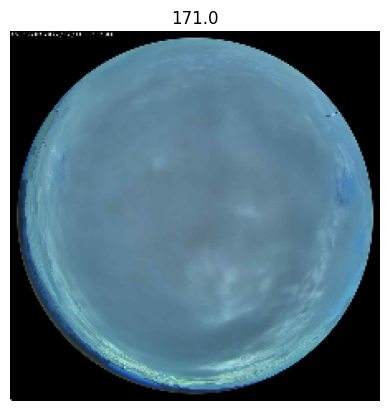

In [20]:
def process_img_label(filepath):
   
   label_path=get_label(filepath)
   label=tf.io.read_file(label_path)
   label=tf.strings.to_number(label)

   #laabel=tf.strings.unicode_decode(label,"UTF8")
   

   img=tf.io.read_file(filepath)
   img=tf.image.decode_jpeg(img)
   img=img/255
   img=tf.image.resize(img, [224,224]) #toujours scale puis resizer pour garder la qualité de l'image

   return img,label

for element in tf_data.map(process_img_label).take(1):
   print(element)

file_path = list(tf_data)[100]
image, label = process_img_label(file_path)

def show(image, label):
  plt.figure()
  print(image.shape)
  print(image)
  plt.imshow(image)
  plt.title(label.numpy())
  plt.axis('off')

show(image, label)

In [21]:
#def scale_img(image,label):
#   return image/255,label

tf_data=tf_data.shuffle(5).map(process_img_label)

In [22]:
#ICI on peut tester petit en prenant moins de donnees donc pas de probleme
train_per=0.8
val_per=0.1
test_per=0.1

len=28000
#car mnin kandir dik len(list(tf_data)) katla3 ram

train_size=int(len*train_per)

val_size=int(len*val_per)

test_size= len-train_size-val_size
#normalement bach mib9ach les donnees: test_size= len(list(images_ds))-train_size-val_size

train_ds=tf_data.take(train_size)
val_ds=tf_data.skip(train_size).take(val_size)
test_ds=tf_data.skip(train_size).skip(val_size).take(test_size)

#print(f"len(train_size)= {train_ds}, len(val_size)={val_ds}, len(test_size)= {val_size}")

In [11]:
for element in train_ds.take(2):
    print(element)

(<tf.Tensor: shape=(400, 400, 3), dtype=float32, numpy=
array([[[3.9215689e-03, 3.9215689e-03, 3.9215689e-03],
        [3.9215689e-03, 3.9215689e-03, 3.9215689e-03],
        [3.8211759e-02, 3.8211759e-02, 3.8211759e-02],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[3.9215689e-03, 3.9215689e-03, 3.9215689e-03],
        [3.9215689e-03, 3.9215689e-03, 3.9215689e-03],
        [2.9952912e-02, 2.9952912e-02, 2.9952912e-02],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[2.1976463e-02, 2.1976463e-02, 2.1976463e-02],
        [7.1685887e-03, 7.1685887e-03, 7.1685887e-03],
        [8.4647053e-01, 8.4647053e-01, 8.4647053e-01],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+0

In [26]:

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras import Input

# Define and compile your model architecture
model = tf.keras.models.Sequential()

model.add(Input(shape=(224,224,3)))
model.add(Conv2D(128,(8,8),(1,1),activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64,(5,5),(1,1),activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(32,(3,3),(1,1),activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(16,(3,3),(1,1),activation="relu"))
model.add(MaxPool2D())

model.add(Flatten())

model.add(Dense(32,activation="relu"))

#model.add(Dense(32,activation="relu"))


model.add(Dense(1,activation="linear"))


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'], run_eagerly=True)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 217, 217, 128)     24704     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 108, 108, 128)    0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 104, 104, 64)      204864    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 52, 52, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 32)        18464     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 25, 25, 32)      

In [24]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds=val_ds.batch(batch_size)


In [28]:
model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=32)

Epoch 1/50
700/700 [==============================] - 394s 563ms/step - loss: 1557.4232 - mean_squared_error: 1557.4232 - val_loss: 1076.3087 - val_mean_squared_error: 1076.3087
Epoch 2/50
700/700 [==============================] - 405s 578ms/step - loss: 953.4911 - mean_squared_error: 953.4911 - val_loss: 807.6640 - val_mean_squared_error: 807.6640
Epoch 3/50
700/700 [==============================] - 407s 581ms/step - loss: 803.9343 - mean_squared_error: 803.9343 - val_loss: 776.1406 - val_mean_squared_error: 776.1406
Epoch 4/50
700/700 [==============================] - 406s 580ms/step - loss: 734.9441 - mean_squared_error: 734.9441 - val_loss: 623.9108 - val_mean_squared_error: 623.9108
Epoch 5/50
700/700 [==============================] - 404s 577ms/step - loss: 669.9152 - mean_squared_error: 669.9152 - val_loss: 635.7513 - val_mean_squared_error: 635.7513
Epoch 6/50
700/700 [==============================] - 404s 577ms/step - loss: 640.6666 - mean_squared_error: 640.6666 - val_lo

In [30]:
print(os.getcwd())
model.save('cnn_model_1.h5')

d:\Stagiaire_2023_Saad\Working space


In [31]:
print("Num GPUs Available: ", (tf.config.experimental.list_physical_devices("GPU")))
print(tf.__version__)


Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


In [ ]:
sample_image, _ = next(iter(train_ds))
print(sample_image.shape)


(400, 400, 3)


In [32]:
test_ds=test_ds.batch(32)



In [33]:
model.evaluate(test_ds)

88/88 [==============================] - 207s 243ms/step - loss: 162.8271 - mean_squared_error: 162.8271


[162.8270721435547, 162.8270721435547]

In [34]:
for element in test_ds.take(5):
    print(element)

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[0.00392157, 0.00392157, 0.00392157],
         [0.00688275, 0.00688275, 0.00688275],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.00110044, 0.00110044, 0.00110044],
         [0.8433974 , 0.8433974 , 0.8433974 ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.07869142, 0.07869142, 0.07869142],
         [0.4658467 , 0.4658467 , 0.4658467 ],
         [0.01734694, 0.01734694, 0.01734694],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        